In [1]:
import os, sys
import numpy as np
from numpy.random import multinomial
import EMdata
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
import itertools
import random, math
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
import time

# Loading Data

In [2]:
#GPU or CPU
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  
device = torch.device(dev) 

In [3]:
#data path
file_path='F:/script/class2vec/real_star_file/10340_case2.star'
datatype=0 #0 is relion 3.1, 1 is relion 3, 2 is cryosparc

file_name=os.path.basename(file_path)
output_path=os.path.dirname(file_path)+'/'+os.path.splitext(file_name)[0]
if os.path.isdir(output_path) is False:
    os.mkdir(output_path)

In [4]:
# parameters
#window size
#w = 4

#ignore classes
#ignore_classes=[3,13,15,44,23,7,22,26,14,28,18,38,47,48,11,35,37]
#ignore_classes=[1,2,3,5,8,10,14,15,17,18,19,21,22,23,24,27,28,31,32,33,34,35,37,38,40,41,44] #GSS20173_300
#ignore_classes=[1,6,7,8,16,17,19,20,21,24,36,38,46] 
#ignore_classes=[14] #10243_tau
#ignore_classes=[2,3,4,11,12,19,20,25,33,36,37,40,43,44,45,46,47,48,49,50] #10340_Case2_tau_ig
#ignore_classes=[2,3,4,11,12,13,19,20,25,33,36,37,40,42,43,44,45,46,47,48,49,50] #10340_Case2_tau_ig by observe
#ignore_classes=[2,5,6,7,12,16,19,23,24,25,30,31,32,33,39,44,45,50] #10340_Case2_tau_ig_E8
#ignore_classes=[]



In [5]:
if datatype<2:
    file_info=EMdata.read_relion(file_path)
    if datatype==0:
        #read data (relion3.1)
        dataset=file_info.getRdata_31()
        optics=file_info.extractoptic()
    else:
        #read relion 3.0
        dataset=file_info.getRdata()
    metadata=dataset[0]
    print(metadata)
    data=dataset[1]
    print(data[0])
    corpus_information=EMdata.process_helical(dataset).extarct_helical_select()
else:
    #read cryosparc
    dataset=np.load(file_path)
    corpus_information=EMdata.process_cryosparc_helical(dataset).extract_helical()
corpus_dic=corpus_information[0]
corpus=list(corpus_dic.values())
corpus_backup=corpus[:]

['_rlnCoordinateX', '_rlnCoordinateY', '_rlnHelicalTubeID', '_rlnAngleTiltPrior', '_rlnAnglePsiPrior', '_rlnHelicalTrackLengthAngst', '_rlnAnglePsiFlipRatio', '_rlnImageName', '_rlnMicrographName', '_rlnOpticsGroup', '_rlnCtfMaxResolution', '_rlnCtfFigureOfMerit', '_rlnDefocusU', '_rlnDefocusV', '_rlnDefocusAngle', '_rlnCtfBfactor', '_rlnCtfScalefactor', '_rlnPhaseShift', '_rlnGroupNumber', '_rlnAngleRot', '_rlnAngleTilt', '_rlnAnglePsi', '_rlnOriginXAngst', '_rlnOriginYAngst', '_rlnClassNumber', '_rlnNormCorrection', '_rlnLogLikeliContribution', '_rlnMaxValueProbDistribution', '_rlnNrOfSignificantSamples']
['3599.945372', '1124.890234', '1', '90.000000', '116.458355', '0.000000', '0.500000', '000001@Extract/job126/Case2/FoilHole_24943298_Data_24944182_24944183_20190125_1637-129188.mrcs', 'Case2/FoilHole_24943298_Data_24944182_24944183_20190125_1637-129188.mrc', '1', '4.172093', '0.180994', '16202.446289', '16096.935547', '54.328850', '0.000000', '1.000000', '0.000000', '1', '0.000000'

In [73]:
corpus_ignore=[]
for i in range(len(corpus)):
    corpus_row=[]
    count=1
    lst=corpus[i]
    for j in range(len(lst)):
        particle=lst[j]
        if j==0:
            count+=particle[1]-1
        if count==int(particle[1]):
            corpus_row.append(particle[0])
            count+=1
        else:
            while 1:
                if count==int(lst[j][1]):
                    corpus_row.append(particle[0])
                    count+=1
                    break
                corpus_row+=[0]
                count+=1               
    corpus_ignore.append(corpus_row)

250


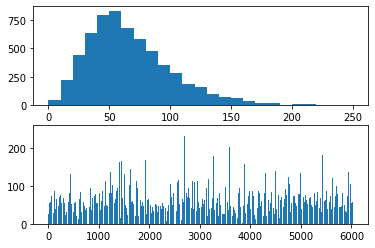

In [74]:
corpus_length_histogram=[]
for i in range(len(corpus_ignore)):
    corpus_length_histogram.append(len(corpus_ignore[i]))
fig,ax=plt.subplots(2)
ax[0].hist(corpus_length_histogram,list(range(0,max(corpus_length_histogram)+10,10)))
ax[1].bar(list(range(0,len(corpus_backup))),corpus_length_histogram)
print(max(corpus_length_histogram))
plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+"length_histogram.png",bbox_inches='tight', pad_inches=0.01)

# Pre-processing

In [75]:
#k-mer seperation
def overlaping_kmer(data,k):
    kmer_corpus=[]
    for i in range(len(data)):
        lst=data[i]
        kmer_lst=[]
        for j in range(len(lst)-k+1):
            kmer_lst.append(str(lst[j])+'-'+str(lst[j+1]))
        kmer_corpus.append(kmer_lst)
    return kmer_corpus

In [76]:
def cut_corpus(corpus,cut_length):
    new_corpus=[]
    cut_length=cut_length
    print(len(corpus))
    for i in range(len(corpus)):
        lst=corpus[i]
        n=len(lst)
        if n<cut_length:
            new_corpus.append(lst)
            continue
        cut_amount=int((n-n%cut_length)/cut_length)
        for j in range(cut_amount-1):
            new_corpus.append(lst[j*cut_length:(j+1)*cut_length])
        new_corpus.append(lst[(cut_amount-1)*cut_length:])
    print(len(new_corpus))
    return new_corpus

In [77]:
#corpus=overlaping_kmer(corpus_backup,2)
#corpus_context=corpus[:]

In [78]:
vocabulary = set(itertools.chain.from_iterable(corpus_ignore))
vocabulary_size = len(vocabulary)
print(vocabulary_size)

42


In [79]:
word_to_index = {w: idx for (idx, w) in enumerate(vocabulary)}
index_to_word = {idx: w for (idx, w) in enumerate(vocabulary)}

In [80]:
#corpus=cut_corpus(corpus_backup,60)
#corpus_context=corpus_backup[:]

In [81]:
def sample_negative(sample_size):
    sample_probability = {}
    word_counts = dict(Counter(list(itertools.chain.from_iterable(corpus_ignore))))
    normalizing = sum([v**0.75 for v in word_counts.values()])
    for word in word_counts:
        sample_probability[word] = word_counts[word]**0.75 / normalizing
    words = np.array(list(word_counts.keys()))
    while True:
        word_list = []
        sampled_index = np.array(multinomial(sample_size, list(sample_probability.values())))
        for index, count in enumerate(sampled_index):
            for _ in range(count):
                 word_list.append(words[index])
        yield word_list

In [82]:
# convert to windoes vector
w = 4
context_tuple_list = []
negative_samples = sample_negative(4)

for text in corpus_ignore:
    for i, word in enumerate(text):
        if word==0:
            continue
        first_context_word_index = max(0,i-w)
        last_context_word_index = min(i+w, len(text))
        for j in range(first_context_word_index, last_context_word_index):
            if word==0:
                continue
            if i!=j:
                context_tuple_list.append((word, text[j], next(negative_samples)))
print("There are {} pairs of target and context words".format(len(context_tuple_list)))

There are 2720350 pairs of target and context words


# Word2vec

In [83]:
def get_batches(context_tuple_list, batch_size=100):
    random.shuffle(context_tuple_list)
    batches = []
    batch_target, batch_context, batch_negative = [], [], []
    for i in range(len(context_tuple_list)):
        batch_target.append(word_to_index[context_tuple_list[i][0]])
        batch_context.append(word_to_index[context_tuple_list[i][1]])
        batch_negative.append([word_to_index[w] for w in context_tuple_list[i][2]])
        if (i+1) % batch_size == 0 or i == len(context_tuple_list)-1:
            tensor_target = torch.from_numpy(np.array(batch_target)).long().to(device)
            tensor_context = torch.from_numpy(np.array(batch_context)).long().to(device)
            tensor_negative = torch.from_numpy(np.array(batch_negative)).long().to(device)
            batches.append((tensor_target, tensor_context, tensor_negative))
            batch_target, batch_context, batch_negative = [], [], []
    return batches

In [84]:
class Word2Vec(nn.Module):

    def __init__(self, embedding_size, vocab_size):
        super(Word2Vec, self).__init__()
        self.target = nn.Embedding(vocab_size, embedding_size).cuda()
        self.context = nn.Embedding(vocab_size, embedding_size).cuda()

    def forward(self, target_word, context_word, negative_example):
        emb_target = self.target(target_word)
        emb_context = self.context(context_word)
        emb_product = torch.mul(emb_target, emb_context).cuda()
        emb_product = torch.sum(emb_product, dim=1).cuda()
        out = torch.sum(F.logsigmoid(emb_product)).cuda()
        emb_negative = self.context(negative_example)
        emb_product = torch.bmm(emb_negative, emb_target.unsqueeze(2)).cuda()
        emb_product = torch.sum(emb_product, dim=1).cuda()
        out += torch.sum(F.logsigmoid(-emb_product)).cuda()
        return -out

In [85]:
class EarlyStopping():
    def __init__(self, patience=5, min_percent_gain=0.1):
        self.patience = patience
        self.loss_list = []
        self.min_gain = min_percent_gain / 100.
        
    def update_loss(self, loss):
        self.loss_list.append(loss)
        if len(self.loss_list) > self.patience:
            del self.loss_list[0]
    
    def stop(self):
        if len(self.loss_list) == 1:
            return False
        gain = (max(self.loss_list) - min(self.loss_list)) / max(self.loss_list)
        print("Loss gain: {}%".format(gain*100))
        if gain < self.min_gain:
            return True
        else:
            return False
        

In [86]:
embedding_size=30
loss_function = nn.CrossEntropyLoss()
net = Word2Vec(embedding_size=embedding_size, vocab_size=vocabulary_size)
optimizer = optim.Adam(net.parameters())
early_stopping = EarlyStopping(patience=5, min_percent_gain=1)
n=0
while True:
    n=n+1
    print(n)
    losses = []
    context_tuple_batches = get_batches(context_tuple_list, batch_size=1000)
    for i in range(len(context_tuple_batches)):
        net.zero_grad()
        target_tensor, context_tensor, negative_tensor = context_tuple_batches[i]
        loss = net(target_tensor, context_tensor, negative_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.data)
    print("Loss: ", torch.mean(torch.stack(losses)),torch.stack(losses)[0],torch.stack(losses)[-1])
    early_stopping.update_loss(torch.mean(torch.stack(losses)))
    if early_stopping.stop() is True:
        break
    if torch.mean(torch.stack(losses))<10:
        break

1
Loss:  tensor(1347.0551, device='cuda:0') tensor(7366.9536, device='cuda:0') tensor(284.9677, device='cuda:0')
2
Loss:  tensor(734.1312, device='cuda:0') tensor(753.7443, device='cuda:0') tensor(255.7797, device='cuda:0')
Loss gain: 45.50102615356445%
3
Loss:  tensor(726.3531, device='cuda:0') tensor(730.5283, device='cuda:0') tensor(237.6035, device='cuda:0')
Loss gain: 46.07843780517578%
4
Loss:  tensor(724.6718, device='cuda:0') tensor(718.0024, device='cuda:0') tensor(239.9462, device='cuda:0')
Loss gain: 46.203250885009766%
5
Loss:  tensor(724.0889, device='cuda:0') tensor(732.2656, device='cuda:0') tensor(247.1344, device='cuda:0')
Loss gain: 46.24652099609375%
6
Loss:  tensor(723.7781, device='cuda:0') tensor(729.7885, device='cuda:0') tensor(239.2004, device='cuda:0')
Loss gain: 1.4102504253387451%
7
Loss:  tensor(723.6267, device='cuda:0') tensor(731.5898, device='cuda:0') tensor(248.3516, device='cuda:0')
Loss gain: 0.3753601908683777%


In [87]:
print(context_tuple_list[0])

(16, 14, [41, 16, 21, 6])


# Show 2D class embedding

In [88]:
import umap
import sklearn
from sklearn.cluster import KMeans,SpectralClustering,MeanShift, estimate_bandwidth,AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from scipy.spatial.distance import cdist
from scipy.stats import multivariate_normal 
from sklearn.decomposition import PCA
import matplotlib.patches as mpatches

EMBEDDINGS.shape:  (42, 30)
1
2
3
4
5
6
7
8


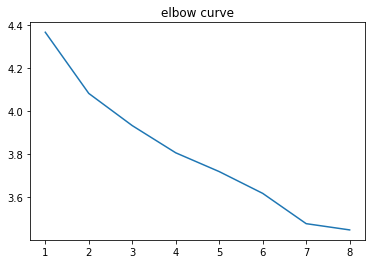

In [89]:
EMBEDDINGS = net.target.weight.data.cpu().numpy()
print('EMBEDDINGS.shape: ', EMBEDDINGS.shape)

res = []
n_cluster = range(1,9)
for n in n_cluster:
    print(n)
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(EMBEDDINGS)
    res.append(np.average(np.min(cdist(EMBEDDINGS, kmeans.cluster_centers_, 'euclidean'), axis=1)))
        
plt.plot(n_cluster, res)
plt.title('elbow curve')
plt.show()

D:\ProgramData\Anaconda3\lib\site-packages\umap\umap_.py:1679: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  "n_neighbors is larger than the dataset size; truncating to "


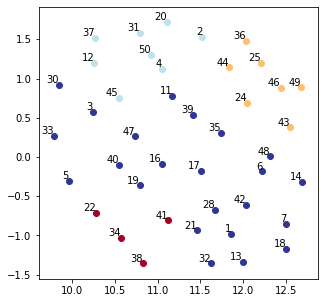

In [90]:
# see the 2D class segments embedding
class_umap=umap.UMAP(n_neighbors=50,min_dist=0,n_components=2).fit_transform(EMBEDDINGS)
cluster_number=6
kmeans_best = SpectralClustering(n_clusters=cluster_number).fit_predict(class_umap)
EMBEDDINGS_np=np.array(EMBEDDINGS)
plt.figure(figsize = (5,5))
for i in range(vocabulary_size):
    # print('vocab_idx: ', vocab_idx)
    plt.scatter(class_umap[i][0], class_umap[i][1],color=plt.cm.RdYlBu(kmeans_best[i]/3))
    plt.annotate(index_to_word[i], xy = (class_umap[i][0], class_umap[i][1]), \
        ha='right',va='bottom')
plt.savefig(output_path+'/'+'w2v.png')
plt.show()

In [24]:

#word_to_cluster={}
#for i in range(cluster_number):
#    word_to_cluster[str(i)]= np.array(np.where(kmeans_best==i)).ravel()+1
#print(word_to_cluster)

##using the histogram method to cluster 



#cluster_corpus=corpus[:]
#for i in range(cluster_number):
#    cluster_lst=list(word_to_cluster[str(i)])
#    for j in range(len(cluster_corpus)):
#        filament=cluster_corpus[j]
#        filament=[i if np.int64(x) in cluster_lst else x for x in filament]
#        cluster_corpus[j]=filament

#filament_cluster_percentage=[]
#for filament in cluster_corpus:
#    filament_lenghth=len(filament)
#    pert=[]
#    for i in range(cluster_number):
#        cluster_per=float(filament.count(i))/filament_lenghth
#        pert.append(cluster_per)
#    filament_cluster_percentage.append(pert)

#histogram clustering
#pca_filaments = PCA(n_components=2).fit_transform(filament_cluster_percentage)
#plt.figure(figsize = (5, 5))
#for i in range(len(cluster_corpus)):
#    plt.scatter(pca_filaments[i][0], pca_filaments[i][1],color='blue')
#plt.savefig("cluster.png")
#plt.show()

# Show Filament Embedding and cluster

In [93]:
# average filament embedding
filament_all=np.zeros((len(corpus_ignore),max(corpus_length_histogram)))
filament_all_embedding=np.array([[np.zeros(30)]*max(corpus_length_histogram)]*len(corpus))
for i in range(len(corpus_ignore)):
    filament=corpus_ignore[i]
    filament_list=[]
    filament_list_score=[]
    for j in filament:
        filament_list_score.append(EMBEDDINGS[word_to_index[j]])
        filament_list.append(word_to_index[j])
    filament_list_score=np.array(filament_list_score)
    filament_all_embedding[i][0:len(filament)]=filament_list_score
    filament_all[i][0:len(filament)]=np.array(filament_list)
print(counts)
#filament_normalized=np.exp(-0.5*((filament_list-mean) @ (filament_list-mean).T)).diagonal()/np.sqrt(np.pi**dim)

121


In [94]:
print(np.shape(filament_all_embedding))

(6028, 250, 30)


In [44]:
print(np.shape(filament_all[0]))

(88, 30)


In [101]:
rnn = nn.LSTM(30, 20, 2)
ip = torch.Tensor(filament_all_embedding)
h0 = torch.randn(2, 250, 20)
c0 = torch.randn(2, 250, 20)
output, (hn, cn) = rnn(ip, (h0, c0))

In [102]:
print(hn[0])

tensor([[-0.1549, -0.0212, -0.0480,  ..., -0.2613,  0.0833,  0.0497],
        [-0.1410, -0.0411, -0.0619,  ..., -0.3025,  0.1106,  0.1220],
        [-0.1312, -0.0296, -0.0730,  ..., -0.3250,  0.1088,  0.1530],
        ...,
        [ 0.1823, -0.1151, -0.0491,  ...,  0.1895, -0.0568, -0.0739],
        [ 0.1823, -0.1151, -0.0491,  ...,  0.1895, -0.0568, -0.0739],
        [ 0.1823, -0.1151, -0.0491,  ...,  0.1895, -0.0568, -0.0739]],
       grad_fn=<SelectBackward>)


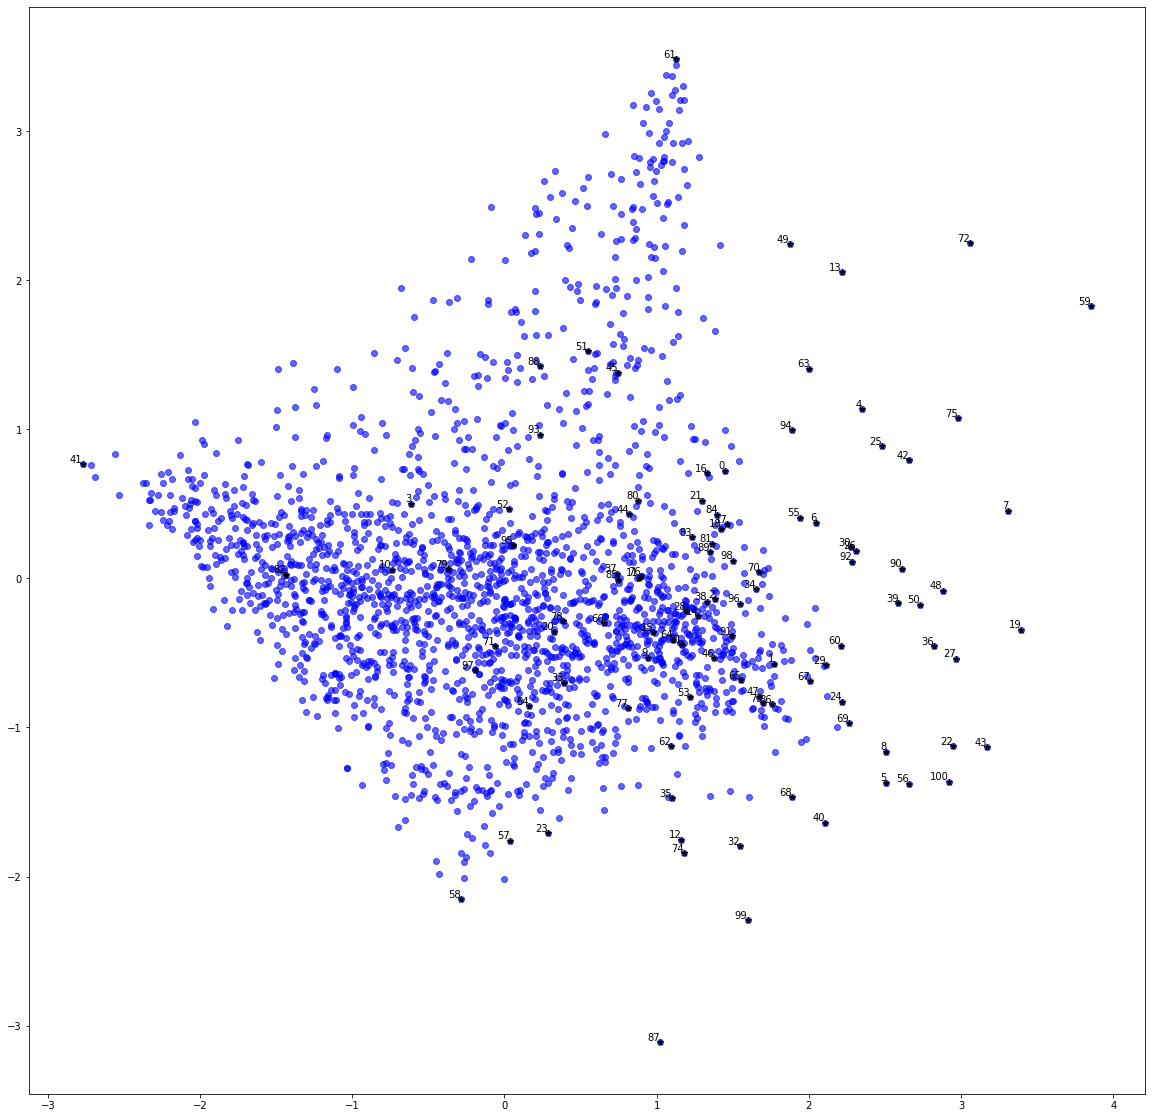

In [123]:
pca_sum = PCA(n_components=2).fit_transform(all_data)
pca_sum_3D = PCA(n_components=3).fit_transform(all_data)
#cluster_pca = KMeans(n_clusters=3).fit_predict(pca_sum[0:len(corpus)])

plt.figure(figsize = (20, 20))
plt.scatter(pca_sum[:,0], pca_sum[:,1],alpha=0.6,color='blue')
for i in range(len(EMBEDDINGS_np)):
    plt.scatter(pca_sum[i+filament_number][0], pca_sum[i+filament_number][1],color='black',marker='*')
    plt.annotate(index_to_word[i], xy = (pca_sum[i+filament_number][0], pca_sum[i+filament_number][1]), ha='right',va='bottom')
plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+"_pca.png",bbox_inches='tight', pad_inches=0.01)
plt.show()
# color=plt.cm.RdYlBu(pca_Clustering[i]/4)

## Umap of the filament embedding

In [124]:
n_neighbors=20
min_dist=0.2
reducer = umap.UMAP(n_neighbors=n_neighbors,min_dist=min_dist)
umap_2D = reducer.fit_transform(all_data)
umap_3D = umap.UMAP(n_neighbors=n_neighbors,min_dist=min_dist,n_components=3).fit_transform(all_data)
filament_umap=umap_2D[0:filament_number]
filament_umap_3D=umap_3D[0:filament_number]

In [125]:
with open(output_path+'/'+'umap_3D_normal.npy', 'wb') as f:
    np.save(f, filament_umap_3D)
print('finish umap')

finish umap


In [126]:
filament_cluster_number=2
umap_predict=KMeans(n_clusters=filament_cluster_number).fit_predict(filament_umap_3D)
#cluster_umap =  KMeans(n_clusters=filament_cluster_number).fit(umap[0:filament_number])
#cluster_umap = AgglomerativeClustering(n_clusters=filament_cluster_number,distance_threshold=None).fit(umap[0:filament_number])
#umap_predict=cluster_umap.fit_predict(filament_umap)
print('finish')

finish


In [127]:
## higher dimensional umap
#filament_umap_ND=umap.UMAP(n_neighbors=n_neighbors,min_dist=min_dist,n_components=50).fit_transform(all_data)[0:filament_number]
#umap_predict=KMeans(n_clusters=filament_cluster_number).fit_predict(filament_umap)

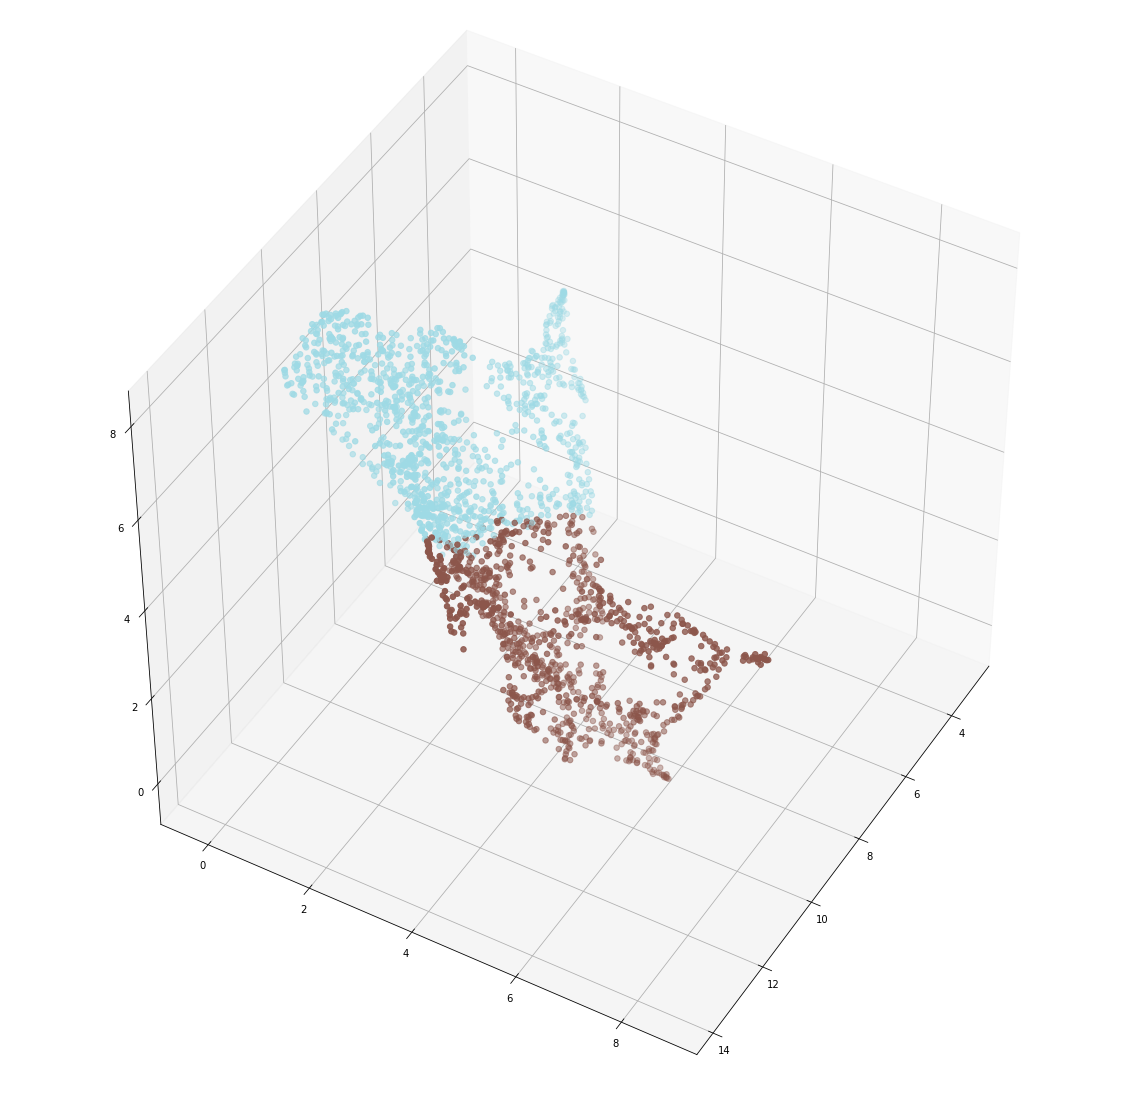

In [128]:
# 3 dimensional umap
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(1,1,1, projection='3d')
ax.scatter(filament_umap_3D[:,0], filament_umap_3D[:,1], filament_umap_3D[:,2], c=plt.cm.tab20((umap_predict+1)/filament_cluster_number), s=30)
ax.view_init(45,30)
plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+"_umap_3D.png",bbox_inches='tight', pad_inches=0.01)
plt.show()

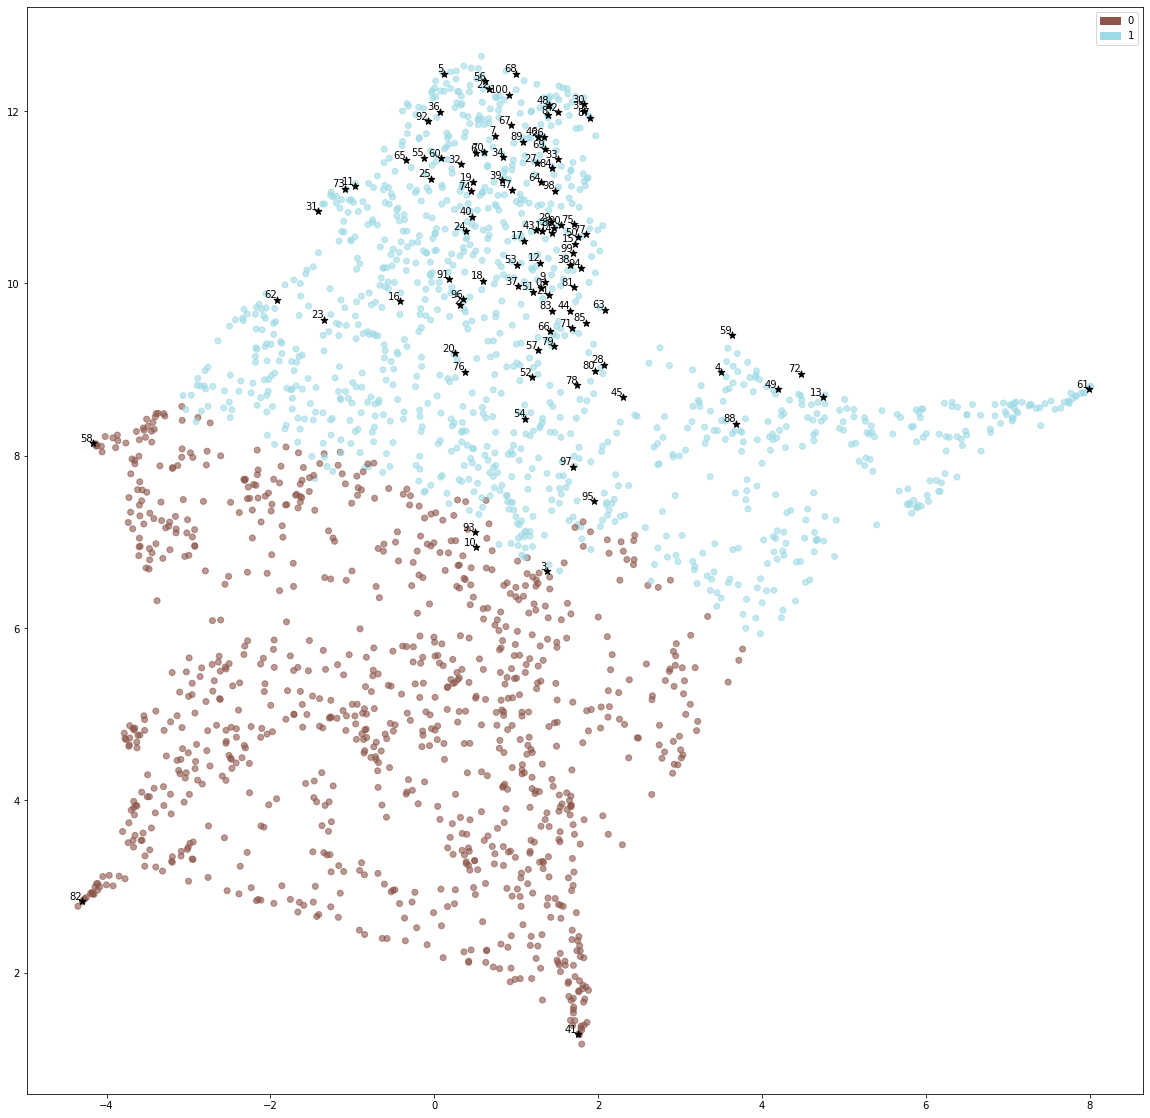

In [129]:
plt.figure(figsize = (20, 20))
for i in range(filament_cluster_number):
    locals()['labels'+str(i)]=mpatches.Patch(color=plt.cm.tab20((i+1)/filament_cluster_number), label=str(i))
plt.legend(handles=[eval('labels'+str(i)) for i in range(filament_cluster_number)])
plt.scatter(filament_umap[:,0], filament_umap[:,1],alpha=0.6,color=plt.cm.tab20((umap_predict+1)/filament_cluster_number))
for i in range(len(EMBEDDINGS_np)):
    plt.scatter(umap_2D[i+filament_number][0], umap_2D[i+filament_number][1],color='black',marker='*',s=50)
    plt.annotate(index_to_word[i], xy = (umap_2D[i+filament_number][0], umap_2D[i+filament_number][1]), ha='right',va='bottom')
plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+"_umap.png",bbox_inches='tight', pad_inches=0.01)
plt.show()
# color=plt.cm.tab20((umap_predict+1)/filament_cluster_number)
# color='blue'

## Seperate the clusters

In [ ]:
for i in range(filament_cluster_number):
    cluster_name='cluster'+str(i)
    cluster_nameID='clusterID'+str(i)
    locals()[cluster_name]=[]
    locals()[cluster_nameID]=[]
data_line=0
cluster_choice=umap_predict
positive_label=[]
for i in range(len(cluster_choice)):
    lst=corpus[i]
    cluster_number=cluster_choice[i]
    cluster_name='cluster'+str(cluster_number)
    cluster_nameID='clusterID'+str(cluster_number)
    for j in range(len(lst)):
        locals()[cluster_name].append(data[data_line])
        locals()[cluster_nameID].append(data[data_line][0][67:70])
        data_line+=1
    positive_label.append(locals()[cluster_nameID][-1]) 

# Compare with the positive labels

In [ ]:
# histogram on rate of successful
#labels=['038','029'] #tau 10230
#labels_name=['PHF','SF']
labels=['124','126'] #tau 10340
labels_name=['singlet','doublet']
distribution_hist_all=[]
for i in range(filament_cluster_number):
    distribution_hist=[]
    lst=locals()['clusterID'+str(i)]
    for j in range(filament_cluster_number):
        group_percentage=lst.count(labels[j])/len(lst)
        distribution_hist.append(group_percentage)
    distribution_hist_all.append(distribution_hist)
print(distribution_hist_all)
print(len(data),len(cluster0),len(cluster1))

fig, ax = plt.subplots(1,filament_cluster_number)

for i in range(filament_cluster_number):
    ax[i].bar(range(filament_cluster_number),distribution_hist_all[i],tick_label =labels_name)
    particle_number=len(locals()['cluster'+str(i)])
    ax[i].set_title('cluster{} amount: {}'.format(i,particle_number))
plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+'distr_new.png')
print('a')

In [ ]:
#label distribution
#from sklearn.manifold import TSNE, MDS,Isomap,SpectralEmbedding
#tsne =SpectralEmbedding(n_components=2,n_neighbors=10).fit_transform(all_data)
#filament_try=tsne[0:filament_number]

positive_label_new=np.array([float(labels.index(x)) for x in positive_label])
with open(output_path+'/'+'positive_label.npy', 'wb') as f:
    np.save(f, filament_umap_3D)
plt.figure(figsize = (20, 20))
for i in range(filament_cluster_number):
    locals()['true_label'+str(i)]=mpatches.Patch(color=plt.cm.tab20(i/(len(labels)+1)), label=labels_name[i])
plt.legend(handles=[eval('true_label'+str(i)) for i in range(len(labels))])
print(len(positive_label))
plt.scatter(filament_umap[:,0], filament_umap[:,1],color=plt.cm.tab20(positive_label_new/3),alpha=0.2)
for i in range(len(EMBEDDINGS_np)):
    plt.scatter(umap_2D[i+filament_number][0], umap_2D[i+filament_number][1],color='black',marker='*',s=50)
    plt.annotate(index_to_word[i], xy = (umap_2D[i+filament_number][0], umap_2D[i+filament_number][1]), ha='right',va='bottom')
plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+"_umap_labels.png",bbox_inches='tight', pad_inches=0.01)
plt.show()

In [ ]:
#seperarte subcluster
for i in range(filament_cluster_number):
    cluster=locals()['cluster'+str(i)]
    lst=locals()['clusterID'+str(i)]
    for j in range(filament_cluster_number):
        subcluster_name='cluster'+str(i)+'_'+str(j)
        locals()[subcluster_name]=[x for x, y in zip(cluster,lst) if y==labels[j]]

# Write .star file for the clusters

In [ ]:
for i in range(filament_cluster_number):
    cluster_name='cluster'+str(i)
    data_cluster=locals()[cluster_name]
    if datatype==0:
        output=EMdata.output_star(output_path+'/'+file_name,i,data_cluster,metadata)
        output.opticgroup(optics)
        output.writecluster()
    elif datatype==1:
        output=EMdata.output_star(output_path+'/'+file_name,i,data_cluster,metadata)
        output.writemetadata()
        output.writecluster()

In [ ]:
# write subcluster relion
for i in range(filament_cluster_number):
    for j in range(filament_cluster_number):
        cluster_name='cluster'+str(i)+'_'+str(j)
        data_cluster=locals()[cluster_name]
        if datatype==0:
            output=EMdata.output_star(output_path+'/'+file_name,str(i)+'_'+str(j),data_cluster,metadata)
            output.opticgroup(optics)
            output.writecluster()
        elif datatype==1:
            output=EMdata.output_star(output_path+'/'+file_name,str(i)+'_'+str(j),data_cluster,metadata)
            output.writemetadata()
            output.writecluster()